# Прекод

# Сборный проект-5

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорты

In [1]:
# ======================
# СТАНДАРТНЫЕ БИБЛИОТЕКИ
# ======================
import logging
import warnings
import os
import re
import random
from typing import List, Optional, Union

# ======================
# НАУЧНЫЕ ВЫЧИСЛЕНИЯ И РАБОТА С ДАННЫМИ
# ======================
import numpy as np
import pandas as pd

# ======================
# ВИЗУАЛИЗАЦИЯ
# ======================
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ======================
# РАБОТА С ИЗОБРАЖЕНИЯМИ
# ======================
from PIL import Image

# ======================
# ПРОГРЕСС-БАРЫ
# ======================
from tqdm import tqdm

# ======================
# МАШИННОЕ ОБУЧЕНИЕ (Scikit-learn)
# ======================
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline

import optuna
from optuna.integration import LightGBMPruningCallback

# ======================
# ДОПОЛНИТЕЛЬНЫЕ ИНСТРУМЕНТЫ
# ======================
import joblib

# ======================
# ГЛУБОКОЕ ОБУЧЕНИЕ (PyTorch)
# ======================
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# ======================
# ТРАНСФОРМЕРЫ (Hugging Face)
# ======================
from transformers import AutoTokenizer, AutoModel

# ======================
# НАСТРОЙКИ ЛОГИРОВАНИЯ И ПРЕДУПРЕЖДЕНИЙ
# ======================
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")

e:\my_github\yandex_practicum_ds\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Константы

In [2]:
RANDOM_STATE = 20
THRESHOLD = 0.6
THRESHOLD_FOR_MODEL = 0.5

EXP_KOEF = 0.8 # коэфициенты "качества" оценки для финального объединения результатов оценок крауда и экспертов
CROW_KOEF = 0.4

IMAGE_FOLDER = "../data/train_images/"          # Папка с изображениями для обучения
IMAGE_FOLDER_TEST = "../data/test_images/"      # Папка с изображениями для теста
IMAGES_TRAIN_EMB = "../data/images_embeddings.pkl"
MERGED_WITH_TEXT_EMB_PATH = "../data/merged_with_text_emb.pkl"
COMBINED_TRAIN_DATASET = "../data/comb_train_dataset.pkl"
RECURSIVE = True
BATCH_SIZE = 32

# Модель BERT для английского языка
BERT_MODEL_NAME = "bert-base-uncased"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {DEVICE}")

2026-02-20 10:24:48 [INFO] __main__: Using device: cuda:0


## Функции проекта

In [3]:
def plot_distribution_with_stats(data, x_column, agg_column=None, title=None):
    """
    Строит гистограмму распределения с линиями статистик (квантили 5%, 50%, 95% и среднее)
    
    Parameters:
    -----------
    data : pandas.DataFrame или str
        DataFrame или путь к файлу с данными
    x_column : str
        Название столбца для построения гистограммы
    agg_column : str, optional
        Столбец для агрегации (если нужно агрегировать значения)
    title : str, optional
        Заголовок графика
    """
    
    # Если на вход подали строку (путь к файлу)
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data.copy()
    
    # Если указан столбец для агрегации, применяем value_counts
    if agg_column:
        plot_data = df[agg_column].value_counts()
        x_label = agg_column
    else:
        plot_data = df[x_column]
        x_label = x_column
    
    plt.figure(figsize=(12, 5))
    
    # Определяем bins для гистограммы
    if agg_column:
        bins = len(plot_data)
        data_for_stats = plot_data.index
        values = plot_data.values
    else:
        bins = len(plot_data.unique())
        data_for_stats = plot_data
        values = plot_data
    
    plt.hist(data_for_stats, bins=bins, alpha=0.7, edgecolor='black')
    
    # Вычисляем статистики
    quantile_05 = data_for_stats.quantile(0.05)
    quantile_50 = data_for_stats.quantile(0.5)
    quantile_95 = data_for_stats.quantile(0.95)
    mean_val = data_for_stats.mean()
    
    # Максимальная частота для высоты линий
    if agg_column:
        max_freq = values.max()
    else:
        max_freq = data_for_stats.value_counts().max()
    
    # Добавляем вертикальные линии
    stats_config = [
        (quantile_05, 'r', '5% значений'),
        (quantile_95, 'r', '95% значений'),
        (quantile_50, 'b', '50% значений'),
        (mean_val, 'orange', 'среднее')
    ]
    
    for x_val, color, label in stats_config:
        plt.vlines(
            x=x_val,
            ymin=0,
            ymax=max_freq + 5,
            colors=color,
            label=label,
            linewidth=2
        )
    
    # Настройка графика
    plt.title(title or f'Распределение {x_label}')
    plt.ylim(top=max_freq + 5)
    plt.legend()
    plt.ylabel('Частота')
    plt.xlabel(x_label)
    
    # Настройка ticks для возраста
    if x_column == 'real_age':
        plt.xticks(range(0, int(data_for_stats.max()), 2))
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Возвращаем статистики для анализа
    stats = {
        '5% квантиль': quantile_05,
        '50% квантиль (медиана)': quantile_50,
        '95% квантиль': quantile_95,
        'среднее': mean_val
    }
    
    return stats


def process_expert_data_simple(df, expert_cols=['exp_1', 'exp_2', 'exp_3'], threshold=0.66):
    """
    Обработка решения экспертов
    """
    result = df.copy()
    
    # Шаг 1: Мажоритарное голосование
    def majority_vote(row):
        votes = row[expert_cols].values
        vote_counts = pd.Series(votes).value_counts()
        return vote_counts.index[0] if vote_counts.iloc[0] >= 2 else np.nan
    
    result['major_target'] = result.apply(majority_vote, axis=1)
    result = result.dropna(subset=['major_target']).copy()
    result['major_target'] = result['major_target'].astype(int)
    
    # # Шаг 2: Нормализация
    # min_val, max_val = 1, 4
    # result['sum_target'] = (result['major_target'] - min_val) / (max_val - min_val)
    
    # # Шаг 3: Бинаризация
    # result['expert_target'] = (result['sum_target'] >= threshold).astype(int)
    
    return result

def show_image_with_all_queries(image_name, merged_df, train_df,
                                images_folder="../data/train_images/",
                                max_queries=5, image_width_inches=5):
    """
    Отображает изображение и только те описания, у которых есть таргет из merged_df.
    Изображение масштабируется к заданной ширине, высота подбирается пропорционально.
    Левая и правая панели выравниваются по вертикали.

    Parameters:
    -----------
    image_name : str
        Название файла изображения
    merged_df : DataFrame
        Датафрейм с колонками image, text_id, sum_target
    train_df : DataFrame
        Датафрейм с колонками image, query_id, query_text
    images_folder : str
        Путь к папке с изображениями
    max_queries : int
        Максимальное количество описаний для отображения
    image_width_inches : float
        Ширина изображения в дюймах (левая панель)
    """
    img_path = os.path.join(images_folder, image_name)

    if not os.path.exists(img_path):
        logger.info(f"Файл не найден: {img_path}")
        return

    # Данные для этого image
    merged_for_image = merged_df[merged_df['image'] == image_name]
    if len(merged_for_image) == 0:
        logger.info(f"Нет данных для изображения {image_name} в merged_df")
        return

    train_for_image = train_df[train_df['image'] == image_name]

    # Словарь таргетов
    target_dict = {row['text_id']: row['sum_target'] for _, row in merged_for_image.iterrows()}

    # Описания с таргетом
    descriptions = []
    for _, row in train_for_image.iterrows():
        if row['query_id'] in target_dict:
            descriptions.append({
                'query_id': row['query_id'],
                'query_text': row['query_text'],
                'sum_target': target_dict[row['query_id']]
            })
    descriptions.sort(key=lambda x: x['sum_target'], reverse=True)

    # Загружаем изображение для определения пропорций
    img = mpimg.imread(img_path)
    img_height, img_width = img.shape[:2]
    aspect = img_height / img_width
    image_height_inches = image_width_inches * aspect

    # Создаём фигуру: левая панель фиксированной ширины, правая подстраивается
    # Общая ширина фигуры = ширина картинки + ширина текста (например, 8 дюймов)
    text_width_inches = 8
    fig_width = image_width_inches + text_width_inches
    fig_height = max(image_height_inches, 6)  # минимальная высота для текста

    fig = plt.figure(figsize=(fig_width, fig_height))

    # Создаём оси вручную, чтобы точно контролировать положение
    left = 0.05
    bottom = 0.05
    right_image = left + image_width_inches / fig_width
    right_text = 0.95

    ax1 = fig.add_axes([left, bottom, image_width_inches / fig_width, image_height_inches / fig_height])
    ax2 = fig.add_axes([right_image + 0.02, bottom, (right_text - right_image - 0.02), image_height_inches / fig_height])

    # Отображаем изображение
    ax1.imshow(img)
    ax1.set_title(f"{image_name}\nописаний с таргетом: {len(descriptions)}", fontsize=10)
    ax1.axis('off')

    # Текстовая информация
    ax2.axis('off')
    total_in_merged = len(merged_for_image)
    total_in_train = len(train_for_image)
    total_with_target = len(descriptions)

    text_str = f"ИЗОБРАЖЕНИЕ: {image_name}\n"
    text_str += "="*50 + "\n\n"
    text_str += f"Статистика:\n"
    text_str += f"записей в merged_df: {total_in_merged}\n"
    text_str += f"описаний в train_df: {total_in_train}\n"
    text_str += f"описаний С ТАРГЕТОМ: {total_with_target}\n\n"

    if total_with_target > 0:
        pos = sum(1 for d in descriptions if d['sum_target'] >= THRESHOLD)
        neg = total_with_target - pos
        text_str += f"Классы:\n"
        text_str += f"положительных (>={THRESHOLD}): {pos}\n"
        text_str += f"отрицательных (<{THRESHOLD}): {neg}\n\n"

        text_str += f"ОПИСАНИЯ С ТАРГЕТОМ:\n" + "-"*50 + "\n"
        num_to_show = min(max_queries, total_with_target)
        for i in range(num_to_show):
            d = descriptions[i]
            qtext = d['query_text'] if len(d['query_text']) <= 150 else d['query_text'][:150] + "..."
            symb = '+++' if d['sum_target'] >= THRESHOLD else '---'
            text_str += f"{symb} {i+1}: sum_target {d['sum_target']:.3f}\n"
            text_str += f"   {qtext}\n" + "-"*30 + "\n"

        if total_with_target > max_queries:
            text_str += f"\n... и ещё {total_with_target - max_queries}\n"

        avg = sum(d['sum_target'] for d in descriptions) / total_with_target
        text_str += f"\nСредний sum_target: {avg:.3f}\n"
    else:
        text_str += "НЕТ ОПИСАНИЙ С ТАРГЕТОМ\n"
        if len(train_for_image) > 0:
            text_str += "\nПримеры без таргета:\n"
            for _, row in train_for_image.head(3).iterrows():
                text_str += f"   {row['query_id']}\n"

    ax2.text(0.01, 0.99, text_str, transform=ax2.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

    plt.show()

    # return {
    #     'image': image_name,
    #     'total_in_merged': total_in_merged,
    #     'total_in_train': total_in_train,
    #     'with_target': total_with_target,
    #     'positive': pos if total_with_target > 0 else 0,
    #     'negative': neg if total_with_target > 0 else 0
    # }


def show_random_images_with_all_queries(merged_df, train_df, num_images=3,
                                        images_folder="../data/train_images/",
                                        max_queries=5, random_state=None,
                                        min_with_target=1, image_width_inches=5):
    """
    Показывает случайные изображения, у которых есть хотя бы min_with_target описаний с таргетом.
    """
    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    required_cols = ['image', 'text_id', 'sum_target']
    missing = [c for c in required_cols if c not in merged_df.columns]
    if missing:
        logger.info(f"В merged_df отсутствуют: {missing}")
        return

    # Отбираем изображения с нужным числом описаний, имеющих таргет
    images_with_target = []
    for img in merged_df['image'].unique():
        mdf = merged_df[merged_df['image'] == img]
        tdf = train_df[train_df['image'] == img]
        if len(tdf) == 0:
            continue
        target_ids = set(mdf['text_id'].values)
        cnt = sum(1 for tid in tdf['query_id'].values if tid in target_ids)
        if cnt >= min_with_target:
            images_with_target.append(img)

    if not images_with_target:
        logger.info(f"Нет изображений с ≥ {min_with_target} описаниями, имеющими таргет")
        return

    logger.info("="*80)
    logger.info("СЛУЧАЙНЫЕ ИЗОБРАЖЕНИЯ (только с описаниями, имеющими таргет)")
    logger.info("="*80)
    logger.info(f"Всего уникальных изображений в merged_df: {len(merged_df['image'].unique())}")
    logger.info(f"Изображений с ≥ {min_with_target} описанием с таргетом: {len(images_with_target)}")
    logger.info(f"Всего пар в merged_df: {len(merged_df)}")
    pos = len(merged_df[merged_df['sum_target'] >= 0.66])
    neg = len(merged_df) - pos
    logger.info(f"положительных: {pos} ({pos/len(merged_df)*100:.1f}%)")
    logger.info(f"отрицательных: {neg} ({neg/len(merged_df)*100:.1f}%)")
    logger.info("-"*80)

    selected = random.sample(images_with_target, min(num_images, len(images_with_target)))
    results = []
    for i, img_name in enumerate(selected, 1):
        logger.info(f"\nИзображение {i}/{len(selected)}: {img_name}")
        mdf = merged_df[merged_df['image'] == img_name]
        tdf = train_df[train_df['image'] == img_name]
        target_ids = set(mdf['text_id'].values)
        with_target = sum(1 for tid in tdf['query_id'].values if tid in target_ids)
        logger.info(f"в merged_df: {len(mdf)} записей, в train_df: {len(tdf)} описаний, с таргетом: {with_target}")
        res = show_image_with_all_queries(
            img_name, merged_df, train_df,
            images_folder=images_folder,
            max_queries=max_queries,
            image_width_inches=image_width_inches
        )
    #     results.append(res)
    # return results

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Подгрузим данные

In [4]:
crowd_df = pd.read_csv("../data/CrowdAnnotations.tsv", sep='\\s+')
expert_df = pd.read_csv("../data/ExpertAnnotations.tsv", sep='\\s+')
test_images = pd.read_csv("../data/test_images.csv")
test_queries = pd.read_csv("../data/test_queries.csv", sep='|')
train_df = pd.read_csv("../data/train_dataset.csv")

### Изучим содержимое данных

#### Оценки

##### crowd_df

In [5]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   1056338697_4f7d7ce270.jpg    47829 non-null  object 
 1   1056338697_4f7d7ce270.jpg#2  47829 non-null  object 
 2   1                            47829 non-null  float64
 3   3                            47829 non-null  int64  
 4   0                            47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [6]:
# у нас нет названий столбцов, добавим
crowd_df.columns = ['image', 'text_id', 'true_%', 'true_count', 'false_count']

In [7]:
display(crowd_df.sample(5))
display(crowd_df.info())

image                      text_id  true_%  \
28499  3234401637_84e0d14414.jpg  3234401637_84e0d14414.jpg#2     1.0   
30364  3294209955_a1f1e2cc19.jpg  3470951932_27ed74eb0b.jpg#2     0.0   
6217   2112921744_92bf706805.jpg  3702436188_2c26192fd0.jpg#2     0.0   
34664  3471841031_a949645ba8.jpg  2549968784_39bfbe44f9.jpg#2     0.0   
16693  2693425189_47740c22ed.jpg  2660008870_b672a4c76a.jpg#2     0.0   

       true_count  false_count  
28499           3            0  
30364           0            3  
6217            0            3  
34664           0            3  
16693           0            3

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47829 non-null  object 
 1   text_id      47829 non-null  object 
 2   true_%       47829 non-null  float64
 3   true_count   47829 non-null  int64  
 4   false_count  47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

In [8]:
crowd_df.describe().T

count      mean       std  min  25%  50%  75%  max
true_%       47829.0  0.068766  0.207490  0.0  0.0  0.0  0.0  1.0
true_count   47829.0  0.208430  0.628775  0.0  0.0  0.0  0.0  5.0
false_count  47829.0  2.820214  0.656556  0.0  3.0  3.0  3.0  6.0

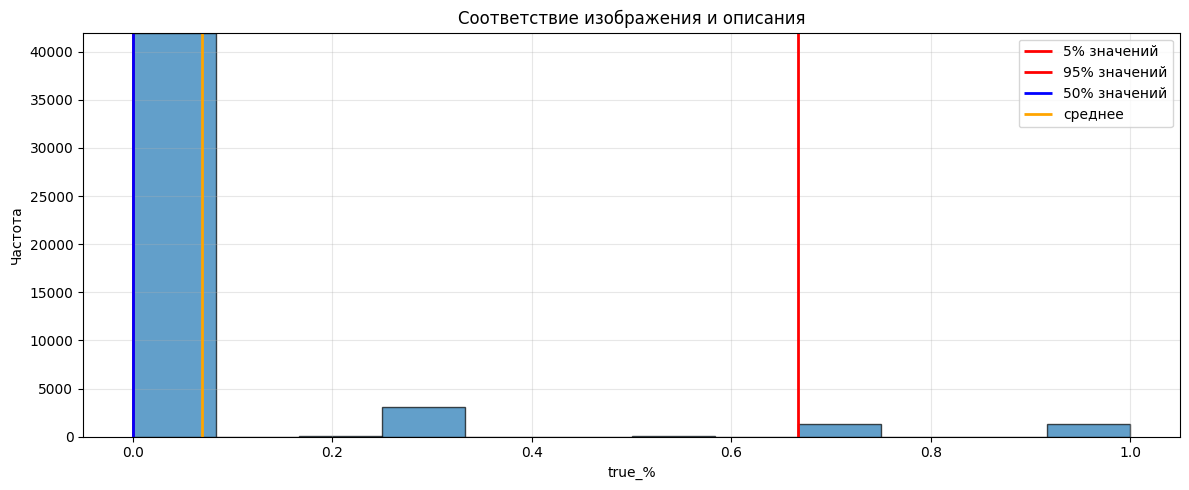

{'5% квантиль': np.float64(0.0),
 '50% квантиль (медиана)': np.float64(0.0),
 '95% квантиль': np.float64(0.666666666666667),
 'среднее': np.float64(0.06876616000055753)}

In [9]:
plot_distribution_with_stats(crowd_df, 'true_%', agg_column=None, title='Соответствие изображения и описания')

Как видим, в данном отчете преобладает то, что текст не соовтетствует описанию, по мнению респондентов.  
В любом случае добавим target, где 1 соответствует при условии, что true_% > 0.66, а все, что ниже - 0. (пока не делаем здесь)

In [10]:
# crowd_df['crowd_target'] = np.where(crowd_df['true_%'] >= 0.66, 1, 0)

In [11]:
crowd_df['true_%'].value_counts()

true_%
0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1322
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: count, dtype: int64

In [12]:
entries_per_image = crowd_df.groupby("image").size().reset_index(name="total_entries")
avg_entries = entries_per_image["total_entries"].mean()
display(f"Среднее количество записей на image: {avg_entries:.2f}")

'Среднее количество записей на image: 47.83'

Слишком много описаний для одной картинки, в итогом варианте оставим только те, у кого оценка выше THRESHOLD

##### expert_df

Теперь посмотрим, как оценили эксперты наши данные

In [13]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   1056338697_4f7d7ce270.jpg    5821 non-null   object
 1   2549968784_39bfbe44f9.jpg#2  5821 non-null   object
 2   1                            5821 non-null   int64 
 3   1.1                          5821 non-null   int64 
 4   1.2                          5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


6000 фотографий против 48000, по всей видимости, качество оценки будет не очень, но это не точно  
позже оценим сравнение как крауда, так и экспертов

In [14]:
expert_df.columns = ['image', 'text_id', 'exp_1', 'exp_2', 'exp_3']

In [15]:
display(expert_df.sample(5))
display(expert_df.info())

image                      text_id  exp_1  exp_2  \
3932  3384314832_dffc944152.jpg   300577375_26cc2773a1.jpg#2      1      1   
5162   424416723_19c56cb365.jpg  3053743109_a2d780c0d2.jpg#2      1      1   
1727  2553550034_5901aa9d6c.jpg  2283966256_70317e1759.jpg#2      1      1   
2922   307327914_f98f576adb.jpg  3145967309_b33abe4d84.jpg#2      1      1   
5159   424416723_19c56cb365.jpg  2189995738_352607a63b.jpg#2      1      1   

      exp_3  
3932      1  
5162      2  
1727      1  
2922      2  
5159      1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    5821 non-null   object
 1   text_id  5821 non-null   object
 2   exp_1    5821 non-null   int64 
 3   exp_2    5821 non-null   int64 
 4   exp_3    5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

In [16]:
expert_df.describe().T

count      mean       std  min  25%  50%  75%  max
exp_1  5821.0  1.436695  0.787130  1.0  1.0  1.0  2.0  4.0
exp_2  5821.0  1.624463  0.856256  1.0  1.0  1.0  2.0  4.0
exp_3  5821.0  1.882151  0.904091  1.0  1.0  2.0  2.0  4.0

In [17]:
# соберем таргет по следующей цепочке - 
# 1) получаем результат посредством мажоритарного голосования (спорное удаляем)
# 2) далее нормализуем между 0 и 1
# 3) далее по принципу >= THRESHOLD это 1 иначе 0

expert_df = process_expert_data_simple(expert_df, expert_cols=['exp_1', 'exp_2', 'exp_3'], threshold=THRESHOLD)

In [18]:
display(expert_df.sample(5))
display(expert_df.describe().T)

image                      text_id  exp_1  exp_2  \
2036  2689001252_e0016c89f0.jpg  2061354254_faa5bd294b.jpg#2      1      1   
3589  3256043809_47258e0b3e.jpg  3256043809_47258e0b3e.jpg#2      4      4   
2653  2966552760_e65b22cd26.jpg   751109943_2a7f8e117f.jpg#2      2      2   
498   1626754053_81126b67b6.jpg  3245070961_8977fdd548.jpg#2      1      1   
3327  3203908917_53e53c03d1.jpg  2774554310_007e980a90.jpg#2      1      1   

      exp_3  major_target  
2036      1             1  
3589      4             4  
2653      2             2  
498       1             1  
3327      1             1

count      mean       std  min  25%  50%  75%  max
exp_1         5695.0  1.441791  0.792755  1.0  1.0  1.0  2.0  4.0
exp_2         5695.0  1.611589  0.859137  1.0  1.0  1.0  2.0  4.0
exp_3         5695.0  1.852502  0.889396  1.0  1.0  2.0  2.0  4.0
major_target  5695.0  1.611589  0.859137  1.0  1.0  1.0  2.0  4.0

In [19]:
# сразу нормализуем
expert_df["expert_norm"] = (expert_df["major_target"] - 1) / 3

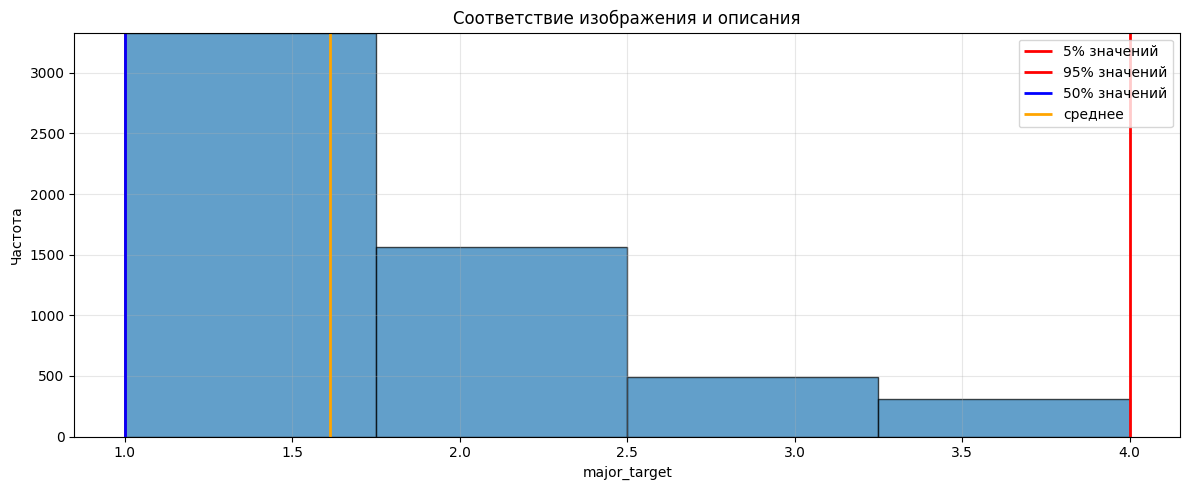

{'5% квантиль': np.float64(1.0),
 '50% квантиль (медиана)': np.float64(1.0),
 '95% квантиль': np.float64(4.0),
 'среднее': np.float64(1.6115891132572433)}

In [20]:
# plot_distribution_with_stats(expert_df, 'sum_target', agg_column=None, title='Соответствие изображения и описания')
plot_distribution_with_stats(expert_df, 'major_target', agg_column=None, title='Соответствие изображения и описания')

Таким образом - мнение экспертов совпадает в целом с мнением крауд разметчиков.  
Значит теперь надо как-то все это обэединить и сделать усредненные значения....

In [21]:
entries_per_image = expert_df.groupby("image").size().reset_index(name="total_entries")
avg_entries = entries_per_image["total_entries"].mean()
display(f"Среднее количество записей на image: {avg_entries:.2f}")

'Среднее количество записей на image: 5.70'

Вот тут уже ближе к правде, по числу описаний

##### train_df

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


##### объединение оценок

In [23]:
merged_df = pd.merge(
    expert_df, 
    crowd_df, 
    on=['image', 'text_id'], 
    how='inner',
    suffixes=('_expert', '_crowd')
)


# merged_df = expert_df

In [24]:
merged_df.sample(5)

image                      text_id  exp_1  exp_2  \
2042   447111935_5af98563e3.jpg  2511019188_ca71775f2d.jpg#2      3      3   
478   2393264648_a280744f97.jpg   524105255_b346f288be.jpg#2      1      1   
1700  3498327617_d2e3db3ee3.jpg  2938747424_64e64784f0.jpg#2      3      3   
2151   537559285_29be110134.jpg   249394748_2e4acfbbb5.jpg#2      1      2   
1259  3168123064_d1983b8f92.jpg  3301859683_2d5e4b40a3.jpg#2      1      2   

      exp_3  major_target  expert_norm    true_%  true_count  false_count  
2042      3             3     0.666667  0.333333           1            2  
478       2             1     0.000000  0.000000           0            3  
1700      3             3     0.666667  0.000000           0            3  
2151      2             2     0.333333  0.000000           0            3  
1259      2             2     0.333333  0.000000           0            3

Теперь сделаем финальный таргет - возьмем коэффициенты.  
0 так и остается 0  
коэффициент для экспертов это EXP_KOEF  
коэффициент для крауда это CROW_KOEF  
просуммируем и нормализуем - это и будет финальная оценка качества описания

In [25]:
merged_df["sum_target"] = (merged_df["expert_norm"] * EXP_KOEF) + (merged_df["true_%"] * CROW_KOEF)
merged_df.describe().T

count      mean       std  min  25%       50%       75%  max
exp_1         2257.0  1.959238  0.988912  1.0  1.0  2.000000  3.000000  4.0
exp_2         2257.0  2.197607  0.981628  1.0  1.0  2.000000  3.000000  4.0
exp_3         2257.0  2.459016  0.929820  1.0  2.0  2.000000  3.000000  4.0
major_target  2257.0  2.197607  0.981628  1.0  1.0  2.000000  3.000000  4.0
expert_norm   2257.0  0.399202  0.327209  0.0  0.0  0.333333  0.666667  1.0
true_%        2257.0  0.200066  0.345807  0.0  0.0  0.000000  0.333333  1.0
true_count    2257.0  0.608330  1.052640  0.0  0.0  0.000000  1.000000  5.0
false_count   2257.0  2.429331  1.065451  0.0  2.0  3.000000  3.000000  6.0
sum_target    2257.0  0.399389  0.378526  0.0  0.0  0.266667  0.666667  1.2

In [26]:
min_value = merged_df["sum_target"].min()
max_value = merged_df["sum_target"].max()

display(min_value)
display(max_value)

np.float64(0.0)

np.float64(1.2000000000000002)

In [27]:
# нормализуем
merged_df["sum_target"] = (merged_df["sum_target"] - min_value) / (max_value - min_value)

In [28]:
# бинаризация таргета
merged_df['target'] = (merged_df['sum_target'] >= THRESHOLD).astype(int)
# merged_df['target'] = (merged_df['expert_norm'] >= THRESHOLD).astype(int)

In [29]:
merged_df.sample(5)

image                      text_id  exp_1  exp_2  \
1446  3294209955_a1f1e2cc19.jpg  2534502836_7a75305655.jpg#2      4      4   
1840  3592968286_b63c81bcd2.jpg  3393343330_b13df4d8ec.jpg#2      1      1   
803   2729655904_1dd01922fb.jpg  3585487286_ef9a8d4c56.jpg#2      3      3   
1032  2950905787_f2017d3e49.jpg  2077079696_03380d218b.jpg#2      3      3   
1510  3354330935_de75be9d2f.jpg  3214237686_6566b8b52f.jpg#2      2      3   

      exp_3  major_target  expert_norm    true_%  true_count  false_count  \
1446      4             4     1.000000  1.000000           3            0   
1840      2             1     0.000000  0.000000           0            3   
803       3             3     0.666667  1.000000           3            0   
1032      3             3     0.666667  0.666667           2            1   
1510      3             3     0.666667  0.666667           2            1   

      sum_target  target  
1446    1.000000       1  
1840    0.000000       0  
803     0.777778       1  
1032    0.666667       1  
1510    0.666667       1

2026-02-20 10:24:51 [INFO] __main__: ================================================================================
2026-02-20 10:24:51 [INFO] __main__: СЛУЧАЙНЫЕ ИЗОБРАЖЕНИЯ (только с описаниями, имеющими таргет)
2026-02-20 10:24:51 [INFO] __main__: ================================================================================
2026-02-20 10:24:51 [INFO] __main__: Всего уникальных изображений в merged_df: 885
2026-02-20 10:24:51 [INFO] __main__: Изображений с ≥ 1 описанием с таргетом: 885
2026-02-20 10:24:51 [INFO] __main__: Всего пар в merged_df: 2257
2026-02-20 10:24:51 [INFO] __main__: положительных: 417 (18.5%)
2026-02-20 10:24:51 [INFO] __main__: отрицательных: 1840 (81.5%)
2026-02-20 10:24:51 [INFO] __main__: --------------------------------------------------------------------------------
2026-02-20 10:24:51 [INFO] __main__: 
Изображение 1/3: 3348385580_10b53391f9.jpg
2026-02-20 10:24:51 [INFO] __main__: в merged_df: 4 записей, в train_df: 5 описаний, с таргетом: 4


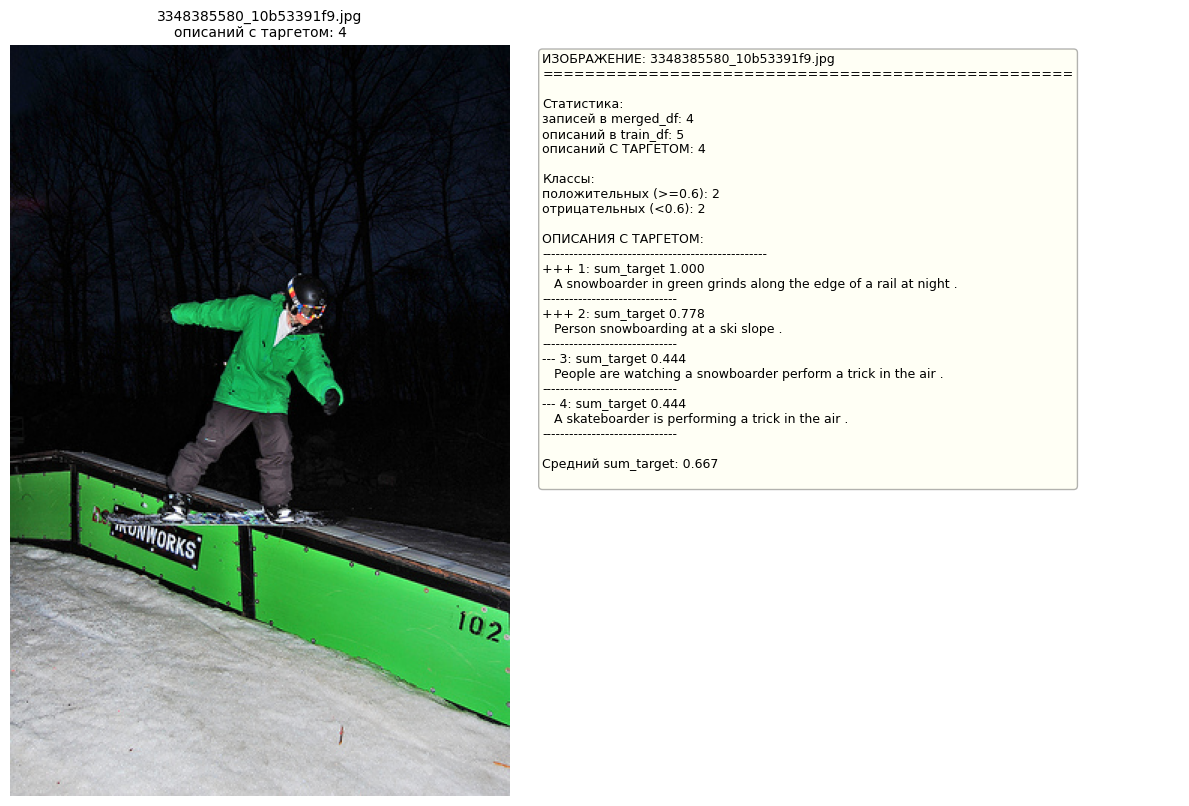

2026-02-20 10:24:51 [INFO] __main__: 
Изображение 2/3: 3572267708_9d8a81d4a4.jpg
2026-02-20 10:24:51 [INFO] __main__: в merged_df: 2 записей, в train_df: 4 описаний, с таргетом: 2


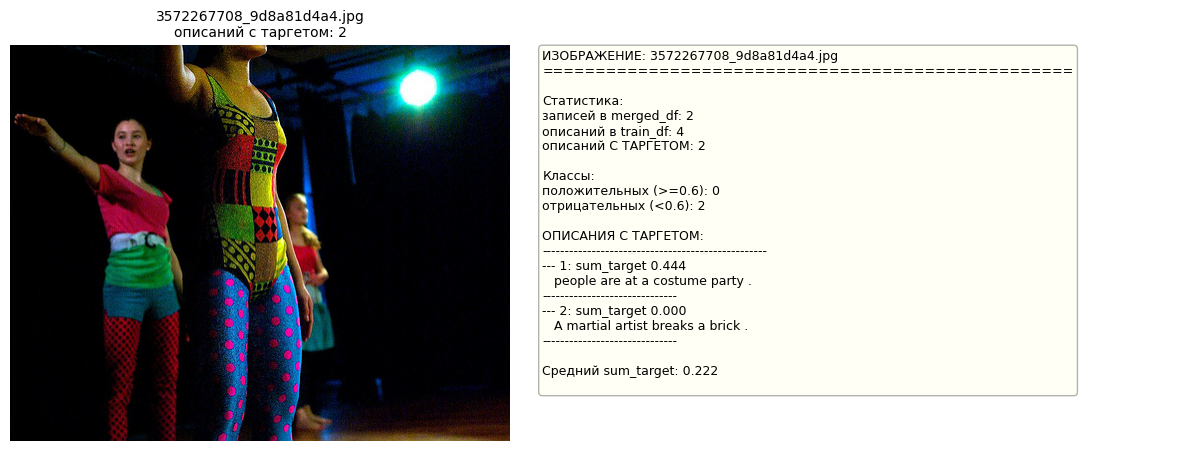

2026-02-20 10:24:51 [INFO] __main__: 
Изображение 3/3: 2206960564_325ed0c7ae.jpg
2026-02-20 10:24:51 [INFO] __main__: в merged_df: 5 записей, в train_df: 8 описаний, с таргетом: 5


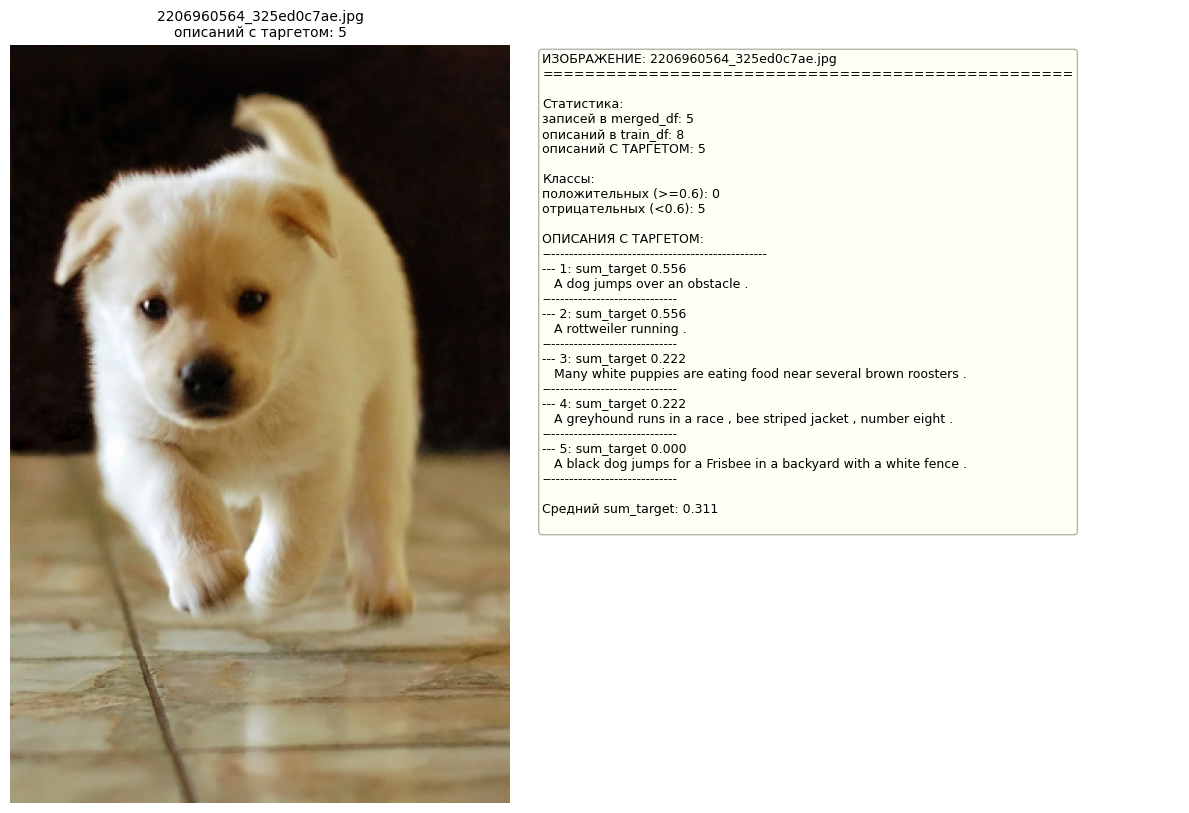

In [30]:
show_random_images_with_all_queries(
    merged_df=merged_df,
    train_df=train_df,
    num_images=3,
    max_queries=5
)

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [31]:
black_list = [
    "child",
    "children",
    "kid",
    "kids",
    "toddler",
    "infant",
    "baby",
    "babies",
    "teenager",
    "teen",
    "adolescent",
    "youth",
    "youngster",
    "minor",
    "boy",
    "girl",
    "preschooler",
    "kindergartener",
    "schoolchild",
    "schoolboy",
    "schoolgirl",
    "juvenile",
    "offspring",
    "progeny",
    "newborn",
    "babe",
    "brat",
    "rugrat",
    "tyke",
    "tot",
    "kiddo",
    "kiddie",
    "kiddies",
    "childhood",
    "babyhood",
    "adolescence",
    "puberty",
    "underage",
    "infancy",
    "toddlerhood",
    "preteen",
    "tween",
    "teenybopper",
    "whippersnapper",
    "urchin",
    "gamin",
    "waif",
    "orphan",
    "family"
]

In [32]:
merged_df = pd.merge(
    merged_df,
    train_df,
    left_on=['image', 'text_id'],
    right_on=['image', 'query_id'],
    how='inner',
    suffixes=('_expert', '_crowd')
)
merged_df.drop(columns=['query_id'], inplace=True)

In [33]:
merged_df.sample(5)

image                      text_id  exp_1  exp_2  \
1727   350443876_c9769f5734.jpg   510531976_90bbee22a2.jpg#2      1      1   
111   1417031097_ab656bc4bd.jpg  2073105823_6dacade004.jpg#2      1      1   
1982  3745451546_fc8ec70cbd.jpg  3123351642_3794f2f601.jpg#2      1      2   
2093   493621130_152bdd4e91.jpg   352382023_7605223d1c.jpg#2      2      2   
1745  3523471597_87e0bf3b21.jpg   160792599_6a7ec52516.jpg#2      1      1   

      exp_3  major_target  expert_norm    true_%  true_count  false_count  \
1727      2             1     0.000000  0.000000           0            3   
111       2             1     0.000000  0.000000           0            3   
1982      2             2     0.333333  0.000000           0            3   
2093      2             2     0.333333  0.333333           1            2   
1745      1             1     0.000000  0.000000           0            3   

      sum_target  target                                         query_text  
1727    0.000000       0  A man balances on his forearms while a child w...  
111     0.000000       0  a person is sliding down a brick rail on a sno...  
1982    0.222222       0  A snowboarder jumps high in the air over a sno...  
2093    0.333333       0  A large brown dog with a stick in his mouth co...  
1745    0.000000       0  Five people standing in front of a body of wat...

In [ ]:
# mask = (merged_df['sum_target'] > THRESHOLD) & \
#        (merged_df['query_text'].str.lower().apply(lambda x: any(word in x for word in black_list)))

# # Удаляем строки, где mask == True
# merged_df = merged_df[~mask].reset_index(drop=True)

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [35]:
def load_model(device):
    """
    Загружает предобученную модель ResNet-18, удаляет классификационный слой,
    переводит в режим eval и перемещает на указанное устройство.
    Возвращает модель и функцию препроцессинга.
    """
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = torch.nn.Identity()  # убираем последний полносвязный слой
    model = model.to(device)
    model.eval()
    return model

def get_preprocess():
    """Возвращает стандартный пайплайн предобработки для ImageNet."""
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return preprocess

def load_image(image_path, preprocess):
    """
    Загружает изображение по пути, применяет препроцессинг и возвращает тензор
    размерности (1, C, H, W) или None в случае ошибки.
    """
    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0)  # добавляем размер batch
        return img_tensor
    except Exception as e:
        logger.info(f"Ошибка загрузки {image_path}: {e}")
        return None

def get_embedding(model, image_tensor, device):
    """
    Принимает тензор изображения (batch=1) и возвращает плоский numpy-вектор эмбеддинга.
    """
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        embedding = model(image_tensor)
    return embedding.cpu().numpy().flatten()

def collect_image_paths(image_folder, recursive=False):
    """
    Собирает все пути к изображениям в указанной папке.
    Возвращает список кортежей (относительный_путь, полный_путь).
    """
    image_paths = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    
    if recursive:
        for root, dirs, files in os.walk(image_folder):
            for file in files:
                if file.lower().endswith(valid_extensions):
                    full_path = os.path.join(root, file)
                    rel_path = os.path.relpath(full_path, image_folder)
                    image_paths.append((rel_path, full_path))
    else:
        for file in os.listdir(image_folder):
            if file.lower().endswith(valid_extensions):
                full_path = os.path.join(image_folder, file)
                image_paths.append((file, full_path))
    
    return image_paths

# --------------------- Основная функция ---------------------

def process_images(image_folder, recursive=False, output_pickle=None, save=True):
    """
    Основная функция для вычисления эмбеддингов изображений.
    
    Параметры:
    ----------
    image_folder : str
        Путь к папке с изображениями.
    recursive : bool
        Если True, просматривать подпапки рекурсивно.
    output_pickle : str или None
        Путь для сохранения результата в формате pickle. 
        Если save=True и output_pickle указан, сохраняет DataFrame.
    save : bool
        Флаг сохранения результата в pickle (если True и указан output_pickle).
    
    Возвращает:
    ----------
    pandas.DataFrame
        DataFrame с колонками 'filename' и 'image_embedding'.
    """
    # 1. Устройство и модель
    device = DEVICE
    model = load_model(device)
    preprocess = get_preprocess()
    
    # 2. Сбор путей изображений
    image_paths = collect_image_paths(image_folder, recursive)
    logger.info(f"Найдено изображений: {len(image_paths)}")
    
    # 3. Обработка каждого изображения
    data = []
    for rel_path, full_path in tqdm(image_paths, desc="Обработка изображений"):
        tensor = load_image(full_path, preprocess)
        if tensor is not None:
            emb = get_embedding(model, tensor, device)
            data.append({"filename": rel_path, "image_embedding": emb})
    
    # 4. Создание DataFrame
    df = pd.DataFrame(data)
    logger.info(f"Успешно обработано: {len(df)} из {len(image_paths)}")
    
    # 5. Сохранение (если требуется)
    if save and output_pickle:
        os.makedirs(os.path.dirname(output_pickle), exist_ok=True)
        df.to_pickle(output_pickle)
        logger.info(f"Результат сохранён в {output_pickle}")
    
    return df

In [36]:
process_images(
    image_folder=IMAGE_FOLDER,
    recursive=False,
    output_pickle=IMAGES_TRAIN_EMB,
    save=True
)

2026-02-20 10:24:52 [INFO] __main__: Найдено изображений: 1000
Обработка изображений: 100%|██████████| 1000/1000 [00:06<00:00, 147.70it/s]
2026-02-20 10:24:59 [INFO] __main__: Успешно обработано: 1000 из 1000
2026-02-20 10:24:59 [INFO] __main__: Результат сохранён в ../data/images_embeddings.pkl


filename  \
0    1056338697_4f7d7ce270.jpg   
1     106490881_5a2dd9b7bd.jpg   
2    1082379191_ec1e53f996.jpg   
3    1084040636_97d9633581.jpg   
4    1096395242_fc69f0ae5a.jpg   
..                         ...   
995   929679367_ff8c7df2ee.jpg   
996    96420612_feb18fc6c6.jpg   
997   968081289_cdba83ce2e.jpg   
998   979383193_0a542a059d.jpg   
999   997722733_0cb5439472.jpg   

                                       image_embedding  
0    [0.6931926, 3.0317724, 2.91727, 0.9516597, 0.9...  
1    [0.64637566, 1.728223, 0.4941744, 0.6524652, 0...  
2    [0.5811475, 0.63622636, 1.2361943, 1.2398282, ...  
3    [0.89194834, 0.700133, 0.744014, 0.21359107, 1...  
4    [1.5568779, 1.0144445, 0.3398144, 1.7168977, 1...  
..                                                 ...  
995  [0.3787658, 1.0551602, 0.4292341, 0.67227983, ...  
996  [0.81921726, 0.70849544, 1.023869, 1.5981421, ...  
997  [0.41333994, 0.92189395, 3.678166, 0.35131532,...  
998  [0.66304606, 0.05080913, 2.279078, 0.0866113, ...  
999  [1.8365865, 0.5382911, 0.54933137, 1.4679028, ...  

[1000 rows x 2 columns]

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [37]:
# =============================================================================
# ФУНКЦИИ ДЛЯ ОЧИСТКИ ТЕКСТА (адаптированные под BERT)
# =============================================================================
EMOJI_PATTERN = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"
    "\U0001F780-\U0001F7FF"
    "\U0001F800-\U0001F8FF"
    "\U0001F900-\U0001F9FF"
    "\U0001FA00-\U0001FAFF"
    "\U00002702-\U000027B0"
    "\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE
)

def clean_text_for_bert(text: str) -> str:
    """
    Базовая очистка текста для BERT:
    - удаление эмодзи,
    - приведение к нижнему регистру,
    - удаление лишних пробелов.
    BERT-base-uncased сам приводит к нижнему регистру, но оставим для прозрачности.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = EMOJI_PATTERN.sub("", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# =============================================================================
# ЗАГРУЗКА МОДЕЛИ И ТОКЕНИЗАТОРА
# =============================================================================
def load_bert_model(model_name: str = BERT_MODEL_NAME, device: torch.device = DEVICE):
    """
    Загружает предобученную модель BERT и токенизатор.
    Возвращает (model, tokenizer).
    """
    logger.info(f"Загрузка модели {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()
    logger.info("Модель загружена.")
    return model, tokenizer

# =============================================================================
# ПОЛУЧЕНИЕ ЭМБЕДДИНГОВ ТЕКСТА
# =============================================================================
def get_bert_embeddings(
    texts: List[str],
    model: nn.Module,
    tokenizer,
    device: torch.device = DEVICE,
    batch_size: int = 32,
    pool_strategy: str = "cls"
) -> np.ndarray:
    """
    Вычисляет эмбеддинги для списка текстов с помощью BERT.
    
    Параметры:
        texts : список строк
        model : загруженная модель BERT
        tokenizer : соответствующий токенизатор
        device : устройство
        batch_size : размер батча
        pool_strategy : 'cls' (использовать [CLS] токен) или 'mean' (усреднение всех токенов)
    
    Возвращает:
        numpy array формы (len(texts), hidden_size)
    """
    model.eval()
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Токенизация с padding/truncation до 512 токенов (максимум BERT)
        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**encoded)
            # outputs.last_hidden_state: (batch, seq_len, hidden)
            if pool_strategy == "cls":
                # Берём эмбеддинг [CLS] токена (первый)
                embeddings = outputs.last_hidden_state[:, 0, :]  # (batch, hidden)
            elif pool_strategy == "mean":
                # Усредняем по длине (игнорируя padding)
                attention_mask = encoded["attention_mask"]
                token_embeddings = outputs.last_hidden_state
                # Суммируем по seq_len и делим на кол-во ненулевых масок
                input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
                sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, dim=1)
                sum_mask = torch.clamp(input_mask_expanded.sum(dim=1), min=1e-9)
                embeddings = sum_embeddings / sum_mask
            else:
                raise ValueError("pool_strategy должен быть 'cls' или 'mean'")
        
        all_embeddings.append(embeddings.cpu().numpy())
    
    return np.vstack(all_embeddings)

def add_text_embeddings_to_df(
    df: pd.DataFrame,
    text_column: str = "query_text",
    model=None,
    tokenizer=None,
    clean_func=clean_text_for_bert,
    batch_size: int = 32,
    pool_strategy: str = "cls",
    cache: bool = True
) -> pd.DataFrame:
    """
    Добавляет в DataFrame колонку 'text_embedding' с эмбеддингами текста.
    Если model или tokenizer не переданы, загружает их автоматически.
    При cache=True кэширует эмбеддинги для уникальных текстов (экономит время).
    """
    if model is None or tokenizer is None:
        logger.info("Модель/токенизатор не переданы, загружаем...")
        model, tokenizer = load_bert_model()
    
    # Очистка текстов
    logger.info("Очистка текстов...")
    texts_clean = df[text_column].astype(str).apply(clean_func).tolist()
    
    if cache:
        # Кэширование по уникальным текстам
        unique_texts = list(set(texts_clean))
        logger.info(f"Найдено {len(unique_texts)} уникальных текстов из {len(texts_clean)}")
        
        # Вычисляем эмбеддинги только для уникальных
        unique_embeddings = get_bert_embeddings(
            unique_texts, model, tokenizer, batch_size=batch_size, pool_strategy=pool_strategy
        )
        # Строим отображение текст -> эмбеддинг
        text_to_emb = dict(zip(unique_texts, unique_embeddings))
        
        # Собираем эмбеддинги для всех строк в исходном порядке
        embeddings = np.array([text_to_emb[t] for t in texts_clean])
    else:
        # Вычисляем для всех подряд
        embeddings = get_bert_embeddings(
            texts_clean, model, tokenizer, batch_size=batch_size, pool_strategy=pool_strategy
        )
    
    df_result = df.copy()
    df_result["text_embedding"] = list(embeddings)
    return df_result

In [38]:
# 1. Проверяем наличие датафреймов
if 'merged_df' not in locals():
    raise ValueError("Переменная merged_df не найдена. Сначала выполните блоки до 11 включительно.")
if 'train_df' not in locals():
    raise ValueError("Переменная train_df не найдена. Сначала загрузите train_df (блок 4).")

logger.info("="*50)
logger.info("ДИАГНОСТИКА ДАННЫХ")
logger.info("="*50)
print("Размер merged_df:", len(merged_df))
print("Колонки merged_df:", merged_df.columns.tolist())
print("Типы данных:\n", merged_df[['image', 'text_id']].dtypes)
print("\nРазмер train_df:", len(train_df))
print("Колонки train_df:", train_df.columns.tolist())
print("Типы данных:\n", train_df[['image', 'query_id', 'query_text']].dtypes)

# Приводим ключевые колонки к строковому типу для надёжности
merged_df['image'] = merged_df['image'].astype(str)
merged_df['text_id'] = merged_df['text_id'].astype(str)
train_df['image'] = train_df['image'].astype(str)
train_df['query_id'] = train_df['query_id'].astype(str)

# Проверяем, есть ли уже текст в merged_df
if 'query_text' in merged_df.columns:
    logger.info("\nКолонка 'query_text' уже присутствует в merged_df. Пропускаем объединение с train_df.")
    df_to_process = merged_df.copy()
else:
    # 2. Объединение для получения текста
    common_images = set(merged_df['image']) & set(train_df['image'])
    logger.info(f"\nПересечение по image: {len(common_images)} изображений")
    if len(common_images) == 0:
        raise ValueError("Нет общих image между merged_df и train_df!")

    merged_pairs = set(zip(merged_df['image'], merged_df['text_id']))
    train_pairs = set(zip(train_df['image'], train_df['query_id']))
    common_pairs = merged_pairs & train_pairs
    logger.info(f"Уникальных пар (image, text_id) в merged_df: {len(merged_pairs)}")
    logger.info(f"Уникальных пар (image, query_id) в train_df: {len(train_pairs)}")
    logger.info(f"Общих пар: {len(common_pairs)}")

    if len(common_pairs) == 0:
        raise ValueError("Нет ни одной общей пары (image, text_id) в train_df!")

    # Объединение
    df_merged = pd.merge(
        merged_df,
        train_df[['image', 'query_id', 'query_text']],
        left_on=['image', 'text_id'],
        right_on=['image', 'query_id'],
        how='inner'
    )
    logger.info(f"\nПосле объединения осталось записей: {len(df_merged)}")
    logger.info(f"Удалено записей (нет текста): {len(merged_df) - len(df_merged)}")

    # Удаляем дублирующую колонку query_id
    if 'query_id' in df_merged.columns:
        df_merged = df_merged.drop(columns=['query_id'])
        logger.info("Колонка query_id удалена.")

    df_to_process = df_merged

# 3. Загрузка BERT (или использование существующей)
if 'bert_model' not in locals() or 'tokenizer' not in locals():
    logger.info("Загружаем BERT модель...")
    bert_model, tokenizer = load_bert_model()
else:
    logger.info("Используем ранее загруженную BERT модель.")

# 4. Добавление эмбеддингов текста
logger.info("\nДобавляем эмбеддинги текста...")
df_with_emb = add_text_embeddings_to_df(
    df_to_process,
    text_column='query_text',   # теперь гарантированно существует
    model=bert_model,
    tokenizer=tokenizer,
    batch_size=32,
    pool_strategy='mean',
    cache=True
)

# 5. Сохраняем результат
os.makedirs(os.path.dirname(MERGED_WITH_TEXT_EMB_PATH), exist_ok=True)
df_with_emb.to_pickle(MERGED_WITH_TEXT_EMB_PATH)
logger.info(f"\nРезультат сохранён в {MERGED_WITH_TEXT_EMB_PATH}")

# 6. Обновляем merged_df и удаляем train_df
merged_df = df_with_emb
del train_df
print("merged_df обновлён (теперь содержит эмбеддинги). train_df удалён.")
print("Размер обновлённого merged_df:", len(merged_df))
print("Колонки:", merged_df.columns.tolist())

2026-02-20 10:24:59 [INFO] __main__: ==================================================
2026-02-20 10:24:59 [INFO] __main__: ДИАГНОСТИКА ДАННЫХ
2026-02-20 10:24:59 [INFO] __main__: ==================================================
2026-02-20 10:24:59 [INFO] __main__: 
Колонка 'query_text' уже присутствует в merged_df. Пропускаем объединение с train_df.
2026-02-20 10:24:59 [INFO] __main__: Загружаем BERT модель...
2026-02-20 10:24:59 [INFO] __main__: Загрузка модели bert-base-uncased...


Размер merged_df: 2186
Колонки merged_df: ['image', 'text_id', 'exp_1', 'exp_2', 'exp_3', 'major_target', 'expert_norm', 'true_%', 'true_count', 'false_count', 'sum_target', 'target', 'query_text']
Типы данных:
 image      object
text_id    object
dtype: object

Размер train_df: 5822
Колонки train_df: ['image', 'query_id', 'query_text']
Типы данных:
 image         object
query_id      object
query_text    object
dtype: object


2026-02-20 10:25:01 [INFO] __main__: Модель загружена.
2026-02-20 10:25:01 [INFO] __main__: 
Добавляем эмбеддинги текста...
2026-02-20 10:25:01 [INFO] __main__: Очистка текстов...
2026-02-20 10:25:01 [INFO] __main__: Найдено 749 уникальных текстов из 2186
2026-02-20 10:25:01 [INFO] __main__: 
Результат сохранён в ../data/merged_with_text_emb.pkl


merged_df обновлён (теперь содержит эмбеддинги). train_df удалён.
Размер обновлённого merged_df: 2186
Колонки: ['image', 'text_id', 'exp_1', 'exp_2', 'exp_3', 'major_target', 'expert_norm', 'true_%', 'true_count', 'false_count', 'sum_target', 'target', 'query_text', 'text_embedding']


In [39]:
merged_df

image                      text_id  exp_1  exp_2  \
0     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
1     1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2      1      1   
2     1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2      2      3   
3     1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2      1      2   
4     1096395242_fc69f0ae5a.jpg  1425069308_488e5fcf9d.jpg#2      2      2   
...                         ...                          ...    ...    ...   
2181   979383193_0a542a059d.jpg  3244747165_17028936e0.jpg#2      2      2   
2182   979383193_0a542a059d.jpg  3482062809_3b694322c4.jpg#2      1      2   
2183   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2      1      1   
2184   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2      1      1   
2185   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2      3      3   

      exp_3  major_target  expert_norm    true_%  true_count  false_count  \
0         2             1     0.000000  0.000000           0            3   
1         2             1     0.000000  0.000000           0            3   
2         3             3     0.666667  0.333333           1            2   
3         2             2     0.333333  0.000000           0            3   
4         2             2     0.333333  0.000000           0            3   
...     ...           ...          ...       ...         ...          ...   
2181      2             2     0.333333  0.000000           0            3   
2182      2             2     0.333333  0.000000           0            3   
2183      1             1     0.000000  0.000000           0            3   
2184      2             1     0.000000  0.000000           0            3   
2185      3             3     0.666667  0.333333           1            2   

      sum_target  target                                         query_text  \
0       0.000000       0  A girl wearing a yellow shirt and sunglasses s...   
1       0.000000       0  A man and woman look back at the camera while ...   
2       0.555556       0       Close-up of dog in profile with mouth open .   
3       0.222222       0                       A dog gets on a trampoline .   
4       0.222222       0  A white dog jumps to catch a blue ball in a li...   
...          ...     ...                                                ...   
2181    0.222222       0  The young adults take a group shot of themselv...   
2182    0.222222       0  A woman posing with a statue alongside a group...   
2183    0.000000       0                        A man sitting on a subway .   
2184    0.000000       0  A man wearing a red hat looks down as another ...   
2185    0.555556       0       A person wearing a white hat climbs a rock .   

                                         text_embedding  
0     [0.50109833, -0.24535342, -0.1348865, -0.14416...  
1     [0.5473464, 0.09250463, 0.21370697, 0.05533928...  
2     [-0.08055469, 0.03605271, -0.1500637, -0.16244...  
3     [0.0011844094, -0.18554215, -0.06400973, 0.105...  
4     [0.056371283, -0.11759077, -0.2559912, 0.09480...  
...                                                 ...  
2181  [0.31183267, 0.23135263, -0.045847256, -0.0159...  
2182  [0.17078733, -0.04849897, -0.08133527, 0.16363...  
2183  [0.15431058, -0.48659903, -0.31762996, -0.0340...  
2184  [0.45529607, 0.24853687, 0.114970975, -0.14562...  
2185  [-0.12320254, -0.102636226, -0.41433287, -0.03...  

[2186 rows x 14 columns]

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [40]:
# 1. Загружаем эмбеддинги изображений
logger.info("Загрузка эмбеддингов изображений...")
images_emb_df = pd.read_pickle(IMAGES_TRAIN_EMB)
logger.info(f"Загружено {len(images_emb_df)} записей")
print("Колонки:", images_emb_df.columns.tolist())

# 2. Приводим ключи к строковому типу для надёжности
images_emb_df['filename'] = images_emb_df['filename'].astype(str)
merged_df['image'] = merged_df['image'].astype(str)

# 3. Проверяем пересечение по ключу
common_images = set(merged_df['image']) & set(images_emb_df['filename'])
print(f"Уникальных image в merged_df: {merged_df['image'].nunique()}")
print(f"Уникальных filename в images_emb_df: {images_emb_df['filename'].nunique()}")
print(f"Общих image: {len(common_images)}")

if len(common_images) == 0:
    raise ValueError("Нет общих изображений! Проверьте формат имён файлов.")

# 4. Выполняем left join, чтобы добавить эмбеддинги
merged_with_img = pd.merge(
    merged_df,
    images_emb_df[['filename', 'image_embedding']],
    left_on='image',
    right_on='filename',
    how='left'
)

# Проверяем наличие пропусков
missing_emb = merged_with_img['image_embedding'].isna().sum()
print(f"Строк без эмбеддинга изображения: {missing_emb} из {len(merged_with_img)}")
if missing_emb > 0:
    logger.info("ВНИМАНИЕ: есть строки без эмбеддинга изображения. Они будут удалены при обучении.")

# Удаляем дублирующую колонку 'filename'
merged_with_img = merged_with_img.drop(columns=['filename'])

# 5. Обновляем merged_df
final_df = merged_with_img
logger.info("\nmerged_df теперь содержит image_embedding.")
print("Размер merged_df:", len(final_df))
print("Колонки:", final_df.columns.tolist())

2026-02-20 10:25:01 [INFO] __main__: Загрузка эмбеддингов изображений...
2026-02-20 10:25:01 [INFO] __main__: Загружено 1000 записей
2026-02-20 10:25:01 [INFO] __main__: 
merged_df теперь содержит image_embedding.


Колонки: ['filename', 'image_embedding']
Уникальных image в merged_df: 873
Уникальных filename в images_emb_df: 1000
Общих image: 873
Строк без эмбеддинга изображения: 0 из 2186
Размер merged_df: 2186
Колонки: ['image', 'text_id', 'exp_1', 'exp_2', 'exp_3', 'major_target', 'expert_norm', 'true_%', 'true_count', 'false_count', 'sum_target', 'target', 'query_text', 'text_embedding', 'image_embedding']


In [41]:
final_df

image                      text_id  exp_1  exp_2  \
0     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
1     1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2      1      1   
2     1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2      2      3   
3     1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2      1      2   
4     1096395242_fc69f0ae5a.jpg  1425069308_488e5fcf9d.jpg#2      2      2   
...                         ...                          ...    ...    ...   
2181   979383193_0a542a059d.jpg  3244747165_17028936e0.jpg#2      2      2   
2182   979383193_0a542a059d.jpg  3482062809_3b694322c4.jpg#2      1      2   
2183   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2      1      1   
2184   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2      1      1   
2185   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2      3      3   

      exp_3  major_target  expert_norm    true_%  true_count  false_count  \
0         2             1     0.000000  0.000000           0            3   
1         2             1     0.000000  0.000000           0            3   
2         3             3     0.666667  0.333333           1            2   
3         2             2     0.333333  0.000000           0            3   
4         2             2     0.333333  0.000000           0            3   
...     ...           ...          ...       ...         ...          ...   
2181      2             2     0.333333  0.000000           0            3   
2182      2             2     0.333333  0.000000           0            3   
2183      1             1     0.000000  0.000000           0            3   
2184      2             1     0.000000  0.000000           0            3   
2185      3             3     0.666667  0.333333           1            2   

      sum_target  target                                         query_text  \
0       0.000000       0  A girl wearing a yellow shirt and sunglasses s...   
1       0.000000       0  A man and woman look back at the camera while ...   
2       0.555556       0       Close-up of dog in profile with mouth open .   
3       0.222222       0                       A dog gets on a trampoline .   
4       0.222222       0  A white dog jumps to catch a blue ball in a li...   
...          ...     ...                                                ...   
2181    0.222222       0  The young adults take a group shot of themselv...   
2182    0.222222       0  A woman posing with a statue alongside a group...   
2183    0.000000       0                        A man sitting on a subway .   
2184    0.000000       0  A man wearing a red hat looks down as another ...   
2185    0.555556       0       A person wearing a white hat climbs a rock .   

                                         text_embedding  \
0     [0.50109833, -0.24535342, -0.1348865, -0.14416...   
1     [0.5473464, 0.09250463, 0.21370697, 0.05533928...   
2     [-0.08055469, 0.03605271, -0.1500637, -0.16244...   
3     [0.0011844094, -0.18554215, -0.06400973, 0.105...   
4     [0.056371283, -0.11759077, -0.2559912, 0.09480...   
...                                                 ...   
2181  [0.31183267, 0.23135263, -0.045847256, -0.0159...   
2182  [0.17078733, -0.04849897, -0.08133527, 0.16363...   
2183  [0.15431058, -0.48659903, -0.31762996, -0.0340...   
2184  [0.45529607, 0.24853687, 0.114970975, -0.14562...   
2185  [-0.12320254, -0.102636226, -0.41433287, -0.03...   

                                        image_embedding  
0     [0.6931926, 3.0317724, 2.91727, 0.9516597, 0.9...  
1     [0.6931926, 3.0317724, 2.91727, 0.9516597, 0.9...  
2     [0.89194834, 0.700133, 0.744014, 0.21359107, 1...  
3     [0.89194834, 0.700133, 0.744014, 0.21359107, 1...  
4     [1.5568779, 1.0144445, 0.3398144, 1.7168977, 1...  
...                                                 ...  
2181  [0.66304606, 0.05080913, 2.279078, 0.0866113, ...  
2182  [0.66304606, 0.05080913, 2.279078, 0

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [42]:
logger.info(f"Размер датасета: {final_df.shape}")
logger.info(f"Колонки: {final_df.columns.tolist()}")
logger.info(f"Распределение target:\n{final_df['target'].value_counts()}")

2026-02-20 10:25:01 [INFO] __main__: Размер датасета: (2186, 15)
2026-02-20 10:25:01 [INFO] __main__: Колонки: ['image', 'text_id', 'exp_1', 'exp_2', 'exp_3', 'major_target', 'expert_norm', 'true_%', 'true_count', 'false_count', 'sum_target', 'target', 'query_text', 'text_embedding', 'image_embedding']
2026-02-20 10:25:01 [INFO] __main__: Распределение target:
target
0    1838
1     348
Name: count, dtype: int64


In [43]:
# =============================================================================
# ПОДГОТОВКА ПРИЗНАКОВ
# =============================================================================
X_img = np.stack(final_df['image_embedding'].values)
X_txt = np.stack(final_df['text_embedding'].values)

X = np.hstack([X_img, X_txt])
y = final_df['target'].values
groups = final_df['image'].values

logger.info(f"X shape: {X.shape}")
logger.info(f"y shape: {y.shape}")
logger.info(f"Unique groups: {len(np.unique(groups))}")

# =============================================================================
# ОДНО ГРУППОВОЕ ДЕЛЕНИЕ TRAIN / TEST
# =============================================================================

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

logger.info(f"Train size: {X_train.shape[0]}")
logger.info(f"Test size:  {X_test.shape[0]}")

# =============================================================================
# ОБУЧЕНИЕ LIGHTGBM
# =============================================================================

lgbm_model = LGBMClassifier(
    random_state=RANDOM_STATE,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    class_weight='balanced',
    verbosity=-1
)

lgbm_model.fit(X_train, y_train)

# =============================================================================
# ПОДБОР ПОРОГА НА TRAIN (но НЕ НИЖЕ THRESHOLD)
# =============================================================================

y_train_proba = lgbm_model.predict_proba(X_train)[:, 1]

thresholds = np.arange(THRESHOLD, 0.99, 0.01)  # начинаем с минимального порога THRESHOLD
best_f1 = 0
best_threshold = 0  # минимальный порог как нижняя граница

for thr in thresholds:
    y_train_pred = (y_train_proba >= thr).astype(int)
    f1 = f1_score(y_train, y_train_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thr

# Сохраняем в глобальную переменную
THRESHOLD_FOR_MODEL = best_threshold
logger.info(f"\nПодобран оптимальный порог: {THRESHOLD_FOR_MODEL:.3f} (F1 на train = {best_f1:.4f})")

# =============================================================================
# ОЦЕНКА НА ТЕСТЕ С ИСПОЛЬЗОВАНИЕМ ПОДОБРАННОГО ПОРОГА
# =============================================================================
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= THRESHOLD_FOR_MODEL).astype(int)

roc_auc = roc_auc_score(y_test, y_test_proba)
f1 = f1_score(y_test, y_test_pred)
acc = accuracy_score(y_test, y_test_pred)

logger.info("\n" + "="*50)
logger.info("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")
logger.info("="*50)
logger.info(f"ROC-AUC:  {roc_auc:.4f}")
logger.info(f"F1:       {f1:.4f} (threshold {THRESHOLD_FOR_MODEL:.3f})")
logger.info(f"Accuracy: {acc:.4f}")
logger.info("\nClassification Report:")
logger.info(classification_report(y_test, y_test_pred))

2026-02-20 10:25:01 [INFO] __main__: X shape: (2186, 1280)
2026-02-20 10:25:01 [INFO] __main__: y shape: (2186,)
2026-02-20 10:25:01 [INFO] __main__: Unique groups: 873
2026-02-20 10:25:01 [INFO] __main__: Train size: 1521
2026-02-20 10:25:01 [INFO] __main__: Test size:  665
2026-02-20 10:25:04 [INFO] __main__: 
Подобран оптимальный порог: 0.600 (F1 на train = 1.0000)
2026-02-20 10:25:04 [INFO] __main__: 
2026-02-20 10:25:04 [INFO] __main__: РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
2026-02-20 10:25:04 [INFO] __main__: ==================================================
2026-02-20 10:25:04 [INFO] __main__: ROC-AUC:  0.6989
2026-02-20 10:25:04 [INFO] __main__: F1:       0.2384 (threshold 0.600)
2026-02-20 10:25:04 [INFO] __main__: Accuracy: 0.8271
2026-02-20 10:25:04 [INFO] __main__: 
Classification Report:
2026-02-20 10:25:04 [INFO] __main__:               precision    recall  f1-score   support

           0       0.86      0.95      0.90       559
           1       0.40      0.17      0.24     

In [44]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

groups_train = groups[train_idx]          # группы только для обучающей выборки

logger.info(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

def objective(trial):
    # --- Внутреннее разделение train/val внутри обучающей выборки ---
    gss_inner = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)
    inner_train_idx, val_idx = next(gss_inner.split(X_train, y_train, groups=groups_train))
    
    X_inner_train = X_train[inner_train_idx]
    X_val = X_train[val_idx]
    y_inner_train = y_train[inner_train_idx]
    y_val = y_train[val_idx]
    
    # --- PCA (обучается только на внутреннем train, применяется к train и val) ---
    pca_dim = trial.suggest_int("pca_dim", 64, 256)
    pca = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
    X_inner_train_pca = pca.fit_transform(X_inner_train)
    X_val_pca = pca.transform(X_val)
    
    # --- Баланс классов ---
    n_pos = y_inner_train.sum()
    n_neg = len(y_inner_train) - n_pos
    scale_pos_weight = n_neg / max(n_pos, 1)
    
    # --- Параметры LightGBM ---
    params = {
        "objective": "binary",
        "metric": "auc",                     # для early stopping используем AUC (стабильнее)
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("lr", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 8, 64),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("l2", 0.0, 5.0),
        "feature_fraction": trial.suggest_float("ff", 0.5, 0.9),
        "bagging_fraction": trial.suggest_float("bf", 0.5, 0.9),
        "bagging_freq": 5,
        "scale_pos_weight": scale_pos_weight,
        "verbosity": -1,
        "random_state": RANDOM_STATE,
    }
    
    dtrain = lgb.Dataset(X_inner_train_pca, label=y_inner_train)
    dval = lgb.Dataset(X_val_pca, label=y_val)
    
    model = lgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        valid_sets=[dval],
        callbacks=[
            LightGBMPruningCallback(trial, "auc"),
            lgb.early_stopping(50, verbose=False),
            lgb.log_evaluation(0)  # ← отключает все логи LightGBM
        ]
    )
    
    # Предсказания на валидации
    y_val_proba = model.predict(X_val_pca)
    
    # Подбор порога, максимизирующего F1 на валидации
    thresholds = np.arange(0.01, 0.99, 0.01)
    best_f1_val = 0.0
    for thr in thresholds:
        y_val_pred = (y_val_proba >= thr).astype(int)
        f1 = f1_score(y_val, y_val_pred)
        if f1 > best_f1_val:
            best_f1_val = f1
    return best_f1_val

2026-02-20 10:25:04 [INFO] __main__: Train size: 1521, Test size: 665


In [45]:
# --- Запуск оптимизации ---
study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=20)
)

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("BEST F1 (val):", study.best_value)
print("BEST PARAMS:", study.best_params)

Best trial: 41. Best value: 0.447619: 100%|██████████| 100/100 [00:17<00:00,  5.77it/s]

BEST F1 (val): 0.44761904761904764
BEST PARAMS: {'pca_dim': 121, 'lr': 0.05284290140795705, 'num_leaves': 57, 'max_depth': 7, 'min_data_in_leaf': 88, 'l1': 3.2049446328270275, 'l2': 3.086344043074959, 'ff': 0.7439253432731082, 'bf': 0.8892175938354998}


In [46]:
# =============================================================================
# ФИНАЛЬНОЕ ОБУЧЕНИЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
# =============================================================================
best_params = study.best_params

# --- Выделим из train финальную train/val выборку (для подбора порога) ---
gss_final = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
final_train_idx, final_val_idx = next(gss_final.split(X_train, y_train, groups=groups_train))

X_final_train_raw = X_train[final_train_idx]
X_final_val_raw = X_train[final_val_idx]
y_final_train = y_train[final_train_idx]
y_final_val = y_train[final_val_idx]

# --- PCA на финальном train ---
pca_final = PCA(n_components=best_params["pca_dim"], random_state=RANDOM_STATE)
X_final_train = pca_final.fit_transform(X_final_train_raw)
X_final_val = pca_final.transform(X_final_val_raw)

# --- Баланс классов для финального обучения ---
n_pos_final = y_final_train.sum()
n_neg_final = len(y_final_train) - n_pos_final
scale_pos_weight_final = n_neg_final / max(n_pos_final, 1)

# --- Параметры финальной модели ---
final_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": best_params["lr"],
    "num_leaves": best_params["num_leaves"],
    "max_depth": best_params["max_depth"],
    "min_data_in_leaf": best_params["min_data_in_leaf"],
    "lambda_l1": best_params["l1"],
    "lambda_l2": best_params["l2"],
    "feature_fraction": best_params["ff"],
    "bagging_fraction": best_params["bf"],
    "bagging_freq": 5,
    "scale_pos_weight": scale_pos_weight_final,
    "verbosity": -1,
    "random_state": RANDOM_STATE,
}

dtrain_final = lgb.Dataset(X_final_train, label=y_final_train)
dval_final = lgb.Dataset(X_final_val, label=y_final_val)

# --- Обучение с early stopping на валидации ---
final_model = lgb.train(
    final_params,
    dtrain_final,
    num_boost_round=1000,
    valid_sets=[dval_final],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(0)]
)

# --- Подбор оптимального порога на валидации (без ограничений) ---
y_val_proba_final = final_model.predict(X_final_val)
thresholds = np.arange(0.01, 0.99, 0.01)
best_f1_val_final = 0.0
best_threshold_final = 0
for thr in thresholds:
    y_val_pred = (y_val_proba_final >= thr).astype(int)
    f1 = f1_score(y_final_val, y_val_pred)
    if f1 > best_f1_val_final:
        best_f1_val_final = f1
        best_threshold_final = thr

THRESHOLD_FOR_MODEL = best_threshold_final
logger.info(f"Лучший порог на валидации: {THRESHOLD_FOR_MODEL:.3f} (F1 = {best_f1_val_final:.4f})")

# =============================================================================
# ОЦЕНКА НА ТЕСТОВОЙ ВЫБОРКЕ
# =============================================================================
X_test_pca = pca_final.transform(X_test)   # используем тот же PCA
y_test_proba = final_model.predict(X_test_pca)
y_test_pred = (y_test_proba >= THRESHOLD_FOR_MODEL).astype(int)

roc_auc = roc_auc_score(y_test, y_test_proba)
f1 = f1_score(y_test, y_test_pred)
acc = accuracy_score(y_test, y_test_pred)

logger.info("\n" + "="*50)
logger.info("РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")
logger.info("="*50)
logger.info(f"ROC-AUC:  {roc_auc:.4f}")
logger.info(f"F1:       {f1:.4f} (threshold = {THRESHOLD_FOR_MODEL:.3f})")
logger.info(f"Accuracy: {acc:.4f}")
logger.info("\nClassification Report:")
logger.info(classification_report(y_test, y_test_pred))

# --- Сохраняем лучшие модели для дальнейшего использования ---
best_lgbm_model = final_model
best_pca = pca_final

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	valid_0's auc: 0.644116


2026-02-20 10:25:22 [INFO] __main__: Лучший порог на валидации: 0.380 (F1 = 0.3487)
2026-02-20 10:25:22 [INFO] __main__: 
2026-02-20 10:25:22 [INFO] __main__: РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
2026-02-20 10:25:22 [INFO] __main__: ==================================================
2026-02-20 10:25:22 [INFO] __main__: ROC-AUC:  0.6383
2026-02-20 10:25:22 [INFO] __main__: F1:       0.3192 (threshold = 0.380)
2026-02-20 10:25:22 [INFO] __main__: Accuracy: 0.5895
2026-02-20 10:25:22 [INFO] __main__: 
Classification Report:
2026-02-20 10:25:22 [INFO] __main__:               precision    recall  f1-score   support

           0       0.89      0.59      0.71       559
           1       0.22      0.60      0.32       106

    accuracy                           0.59       665
   macro avg       0.55      0.60      0.51       665
weighted avg       0.78      0.59      0.64       665



In [47]:
# Применяем PCA к тестовым данным
X_test_pca = best_pca.transform(X_test)   # используем лучший PCA, сохранённый ранее

# Получаем предсказания
y_pred_proba = best_lgbm_model.predict(X_test_pca)

# Далее подбор порога и оценка (если нужно)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
# THRESHOLD_FOR_MODEL = thresholds[best_idx]  # раскомментируйте, если хотите переопределить порог

y_pred = (y_pred_proba >= THRESHOLD_FOR_MODEL).astype(int)

print("THRESHOLD_FOR_MODEL:", THRESHOLD_FOR_MODEL)
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("F1:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

THRESHOLD_FOR_MODEL: 0.38
ROC-AUC: 0.6382522698889527
F1: 0.3192019950124688
Accuracy: 0.5894736842105263


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [48]:
ALERT_TEXT = "This image is unavailable in your country in compliance with local laws"
TOP_N = 1  # число лучших картинок, из которых случайно выбираем

def contains_blacklist(text: str, black_list) -> bool:
    text = str(text).lower()
    return any(word in text for word in black_list)


def predict_best_image_for_query(
    query_text,
    clf_model,
    image_emb_dict,      # словарь {full_path: embedding}
    txt_emb,             # уже вычисленный эмбеддинг текста
    black_list,
    top_n_diversity=5,
    pca_model=None       # <- добавляем PCA
):
    is_blocked = contains_blacklist(query_text, black_list)
    alert = ALERT_TEXT if is_blocked else None

    candidates = []
    
    for image_path, img_emb in image_emb_dict.items():
        X_raw = np.hstack([img_emb, txt_emb]).reshape(1, -1)
        # Применяем PCA, если он есть
        if pca_model is not None:
            X = pca_model.transform(X_raw)
        else:
            X = X_raw
        
        prob = clf_model.predict(X)[0]
        image_name = os.path.basename(image_path)
        candidates.append((prob, image_name, image_path))

    if not candidates:
        return {
            "query_text": query_text,
            "blocked": is_blocked,
            "alert": alert,
            "image_name": "NOT_FOUND",
            "image": np.zeros((224, 224, 3), dtype=np.uint8),
            "prob": 0.0,
            "pred": 0
        }

    candidates.sort(key=lambda x: x[0], reverse=True)
    top_candidates = candidates[:min(top_n_diversity, len(candidates))]
    best_prob, best_image_name, best_image_path = random.choice(top_candidates)
    
    try:
        best_image = Image.open(best_image_path).convert("RGB")
    except:
        best_image = np.zeros((224, 224, 3), dtype=np.uint8)

    return {
        "query_text": query_text,
        "blocked": is_blocked,
        "alert": alert,
        "image_name": best_image_name,
        "image": best_image,
        "prob": best_prob,
        "pred": int(best_prob >= THRESHOLD_FOR_MODEL)
    }


def run_test_inference_new(
    test_queries,
    clf_model,
    image_emb_dict,
    bert_model,
    tokenizer,
    black_list,
    device,
    pca_model=None          # новый параметр
):
    results = []
    for _, row in test_queries.iterrows():
        txt_emb = extract_text_embedding(row["query_text"], bert_model, tokenizer, device)
        res = predict_best_image_for_query(
            query_text=row["query_text"],
            clf_model=clf_model,
            image_emb_dict=image_emb_dict,
            txt_emb=txt_emb,
            black_list=black_list,
            top_n_diversity=TOP_N,
            pca_model=pca_model    # передаём PCA
        )
        results.append(res)
    return results


def extract_text_embedding(text, bert_model, tokenizer, device):
    text_clean = clean_text_for_bert(text)
    emb = get_bert_embeddings(
        [text_clean],
        bert_model,
        tokenizer,
        device=device,
        batch_size=1,
        pool_strategy="mean"
    )[0]
    return emb


def visualize_result(result):
    plt.figure(figsize=(5,5))
    
    if isinstance(result['image'], np.ndarray):
        plt.imshow(result['image'])
    else:
        plt.imshow(np.array(result['image']))
    
    plt.axis('off')
    
    # Формируем заголовок с учетом блокировки
    status = "BLOCKED" if result['blocked'] else "ALLOWED"
    title = f"{status}\nQuery: {result['query_text']}\nProb: {result['prob']:.2f}, Pred: {result['pred']}"
    if result['alert']:
        title += f"\n{result['alert']}"
    
    plt.title(title, fontsize=9, pad=20)
    plt.tight_layout()
    plt.show()

2026-02-20 10:25:22 [INFO] __main__: Загрузка модели bert-base-uncased...
2026-02-20 10:25:24 [INFO] __main__: Модель загружена.


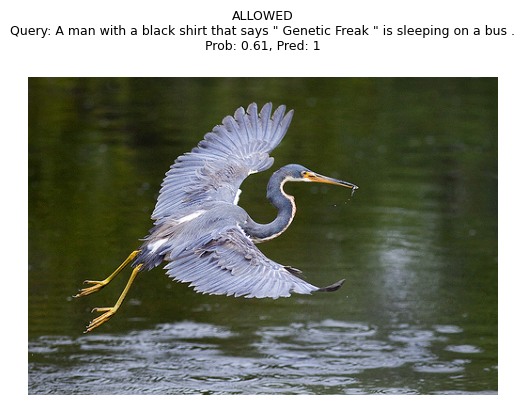

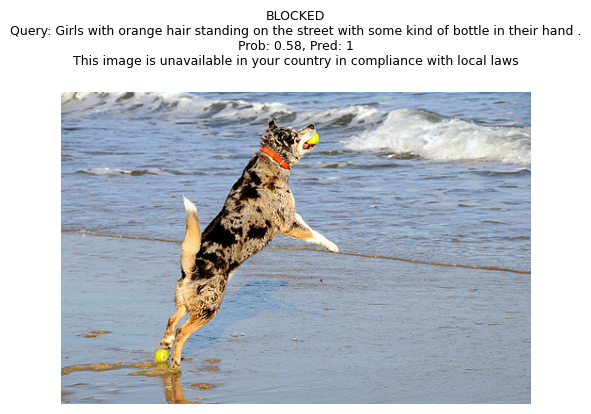

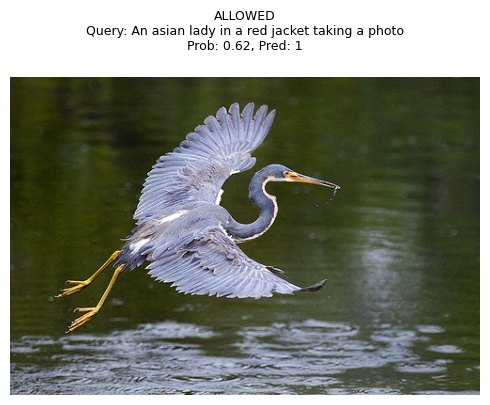

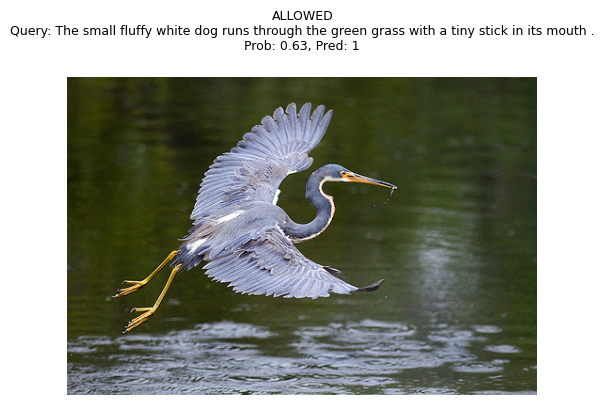

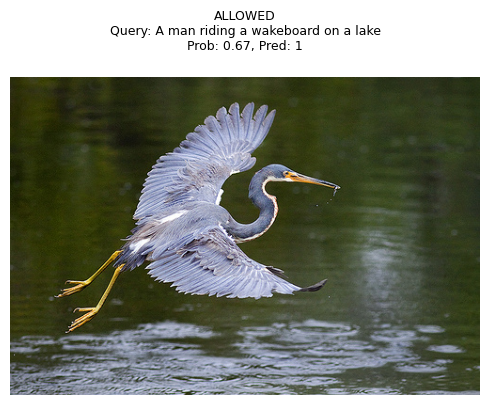

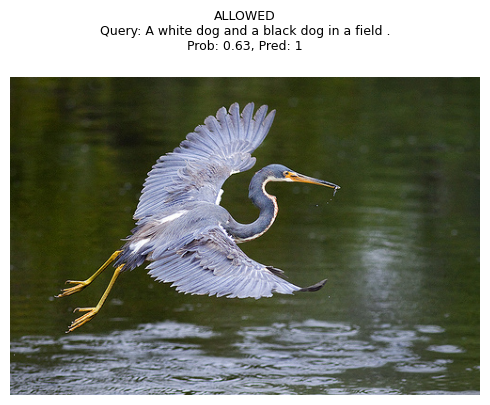

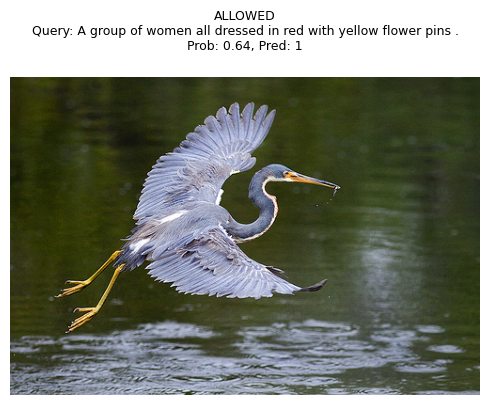

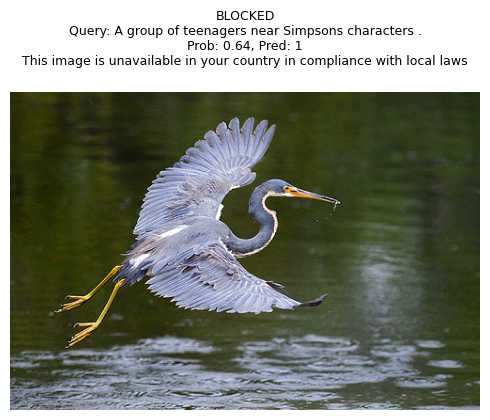

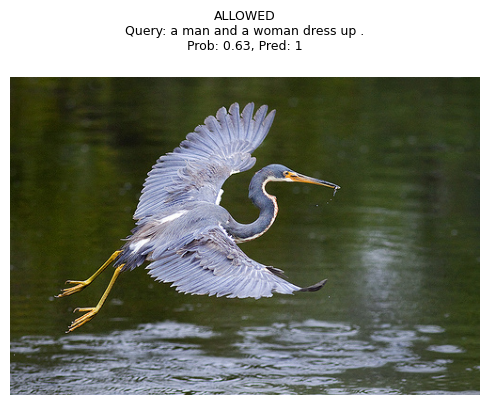

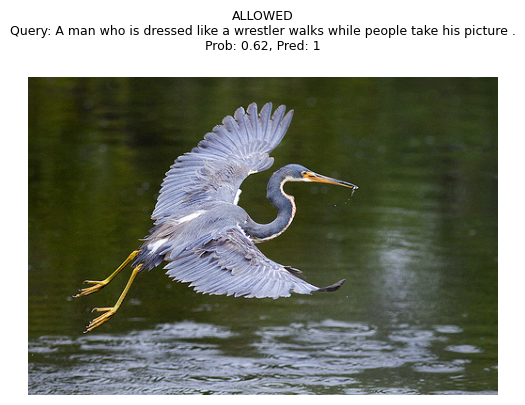

In [49]:
# Подготовка моделей и эмбеддингов
img_model = load_model(DEVICE)
preprocess = get_preprocess()
bert_model, tokenizer = load_bert_model()

# 1. Словарь эмбеддингов тестовых изображений
test_image_paths = collect_image_paths(IMAGE_FOLDER_TEST, recursive=False)
image_emb_dict = {}
for rel_path, full_path in test_image_paths:
    tensor = load_image(full_path, preprocess)
    if tensor is not None:
        image_emb_dict[full_path] = get_embedding(img_model, tensor, DEVICE)

# 2. Случайные 10 запросов
sample_queries = test_queries.sample(n=min(10, len(test_queries)))

# 3. Инференс
results = run_test_inference_new(
    test_queries=sample_queries,
    clf_model=best_lgbm_model,      # ← финальная модель с PCA
    image_emb_dict=image_emb_dict,
    bert_model=bert_model,
    tokenizer=tokenizer,
    black_list=black_list,
    device=DEVICE,
    pca_model=best_pca               # ← передаём PCA
)

# 4. Визуализация
for r in results:
    visualize_result(r)


## Выводы

Честно говоря, вывод не очень...  
1) Мы можем не брать фото с детьми из тренировочной выборки, но они все равно есть в тестовой...  
2) Если модель плохая, что у нас и получилось - фотографии детей надо удалять в принципе отовсюду.  
3) Алерт на запрос с детьми - поможет в большей степени, но нельзя забывать о качестве модели и что она все равно можно выдавать изображения детей, даже на запросы, где дети явно не указаны.  

Подозреваю, у нас здесь 3 проблемы:  
1) Маленкая выборка;  
2) Устаревший вариант;  
3) Отсутствие большого опыта и времени у меня :)  

Вижу, что есть CLiP zero-shot - попробую в следующем блоке реализовать этот подход и сравнить

## CLiP zero-shot

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска